# Kaggle Titanic Survival Competition

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Understanding the dataset

First an foremost I want to understand what the dataset that I am working with looks like. A few general questions that I want to answer are:

- What are the different columns? How many are there?
- What does the data look like?
- What data types are in the dataset?
- How many entries are there in the dataset? 

In [3]:
titanic_df = pd.read_csv('./data/train.csv')

print(titanic_df.columns)
print(len(titanic_df.columns))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
12


In [4]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
print(titanic_df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [6]:
num_entries = titanic_df.shape[0]
print("Number of entries:", num_entries)

Number of entries: 891


## Data Cleaning

In the cleaning process I am doing some data checking and manipulation tasks that will hopefully improve the usability and quality of precitions in the later steps. 

These include:
- Possibly dropping unnecessary columns
- Handling missing values by either removing the entries, or adding data
- Type checking & possibly converting them to more suitable types
- Removing duplicate data
- Possibly adapting granularity of the data (either making it less or more granular)
- Finding outliers and handling them appropriately
- Possibly adding new features with feature engineering

In [7]:
# First I create a deep copy to guarantee that the original dataframe stays as it is
t_df = titanic_df.copy(deep=True)

### Checking for duplicates

First we sort the data, then we check for duplicates. It is important to sort the data first, since the duplicated() method only compare each row to the previous row. So if there are rows between duplicates, the duplicated() method will not catch these.

For the sorting values I chose the 'Ticket' and 'Cabin' features.


In [8]:
# Checking all rows from the original DF for duplicates
t_df_sorted = t_df.sort_values(by=['Ticket', 'Cabin'])
duplicates = t_df_sorted.duplicated()
number_duplicate = duplicates.sum()
print("Number of duplicates:",number_duplicate)

Number of duplicates: 0


### Dropping/ removing columns

As each row already has an ID, the PassengerID column is redundant and can be dropped.

In [9]:
# DF with dropped columns
t_df_dropped = t_df.drop(['PassengerId', 'SibSp', 'Parch'], axis=1)

### Handling missing values

NOTE: Dropping the missing values results in a dataframe with only 183 rows compared to the original 891. Due to the significance of this action, a secondary notebook called *titanic_comp_reduced* deals with the remaining data as a base for further research.

The very first step is to identify where the missing values are situated. It's important to understand why the values are missing. Is there a pattern to the missing data? Is it missing completely at random, or is there a systematic reason? 


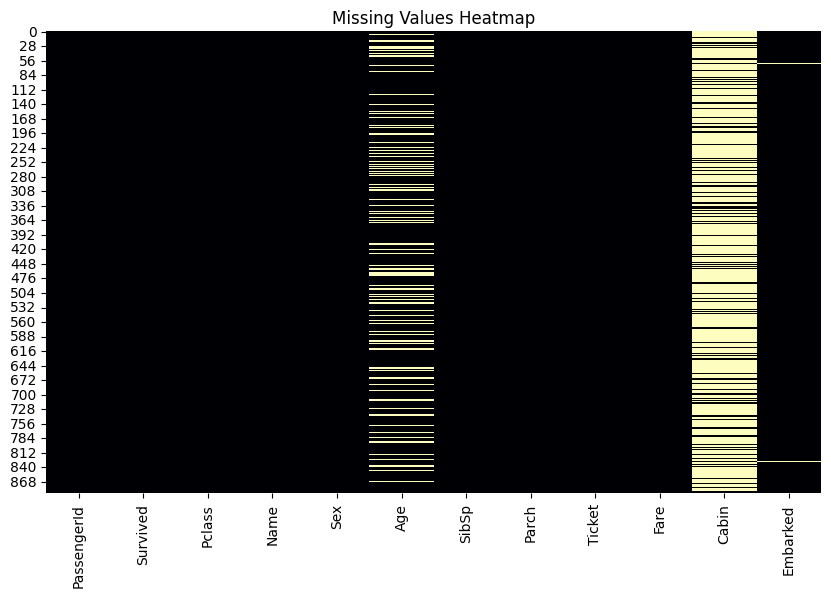

In [14]:
# Create a heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(t_df.isnull(), cmap="magma", cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


After analysing the occurences of the missing data it becomes clear that there are two major columns in question: Age and Cabin. 
Embarked also contains a few missing values. Now there are several options: 

- If a column has a high percentage of missing values and doesn't provide significant information it can be considered for removal.
- If the missing values are limited to a small number of rows, you might consider removing those rows. However, be cautious, as this might result in loss of valuable data.
- Filling the column with placeholders, for example "Uknown" instead of leavint them as NaN or null.
- Imputation, which involves filling in missing values with estimated values (ex.: Mean, Median, Mode).
- Creating multiple versions of the dataset where missing values are imputed differently in each version. This can help capture the uncertainty around imputed values.

One way of dealing with missing values would be to infer the data from similar entries. For example, suppose we have a passenger with a missing value for cabin:

- We could try to find out if they are married to another passenger for which we know the cabin by checking the name.
- We could check if the class gives us a rough estimate of where the cabin would be situated on the ship, or at least what type of cabin it is.
- We could check the price to infer what type of cabin it might be and where it would be located.
- We could check if there are patterns related to the *Embarked* feature, i.e. if people that embarked at the same place got allocated similarly located cabins.

Whilst this may sound sensible, it is by no means a hard and fast rule and could therefore make the model perform worse. It is therefore a good idea to split the datasets into two versions: one where all the entries with missing values are removed, and one where the missing values are inferred from other features.

It is also important to keep in mind what we actually want to find out and if the data is relevant in terms of solving these questions. For further elaboration of the questions to solve, refer to the section *Definition of the questions to be answered*.

Since the rows with missing values are limited to a small number of rows in the *Embarked* column, I am going to remove them altogether since there is no clear way of figuring out the values. One might argue, that the *Embarked* column might not be that relevant altogether and it might be more valuable to keep the two entries and just be done with the *Embarked* column, which is a valid argument. However at the time being we will focus on one path, and might come back later to try and optimise the quality of the model.

In [16]:
df_clean = t_df.dropna(subset=['Embarked'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


/var/folders/6d/y3v3tvc170j90w1hsnzm4jmr0000gn/T/ipykernel_14999/1962671655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cabin'].fillna('Unknown', inplace=True)
/var/folders/6d/y3v3tvc170j90w1hsnzm4jmr0000gn/T/ipykernel_14999/1962671655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Deck'] = df_clean['Cabin'].apply(lambda cabin: cabin[0])


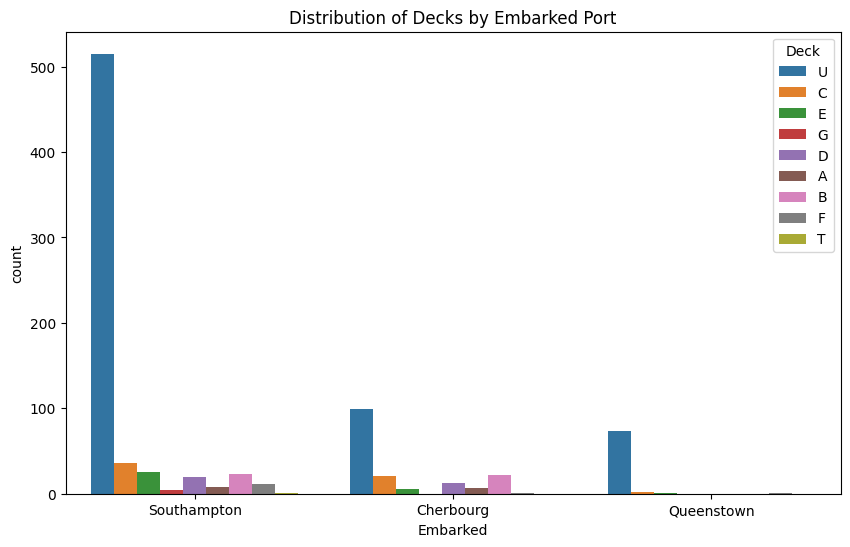

In [35]:
# Replace missing cabin values with 'Unknown'
df_clean['Cabin'].fillna('Unknown', inplace=True)

# Creating a deck column with the first letter of the cabin
df_clean['Deck'] = df_clean['Cabin'].apply(lambda cabin: cabin[0])

# Create a categorical plot using catplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Embarked', data=df_clean, hue='Deck')
plt.title("Distribution of Decks by Embarked Port")
custom_labels = ['Southampton', 'Cherbourg', 'Queenstown']
ax.set_xticklabels(custom_labels)
plt.show()

As we can see there is no clear pattern of place of embarkment and designated deck. There might be one, but with all the missing data from the cabins it is not possible to draw conclusions. We will just leave the cabin and deck data as it is for the time being.

To make sure that there are no mising values left, we can re-plot the heatmap graph.

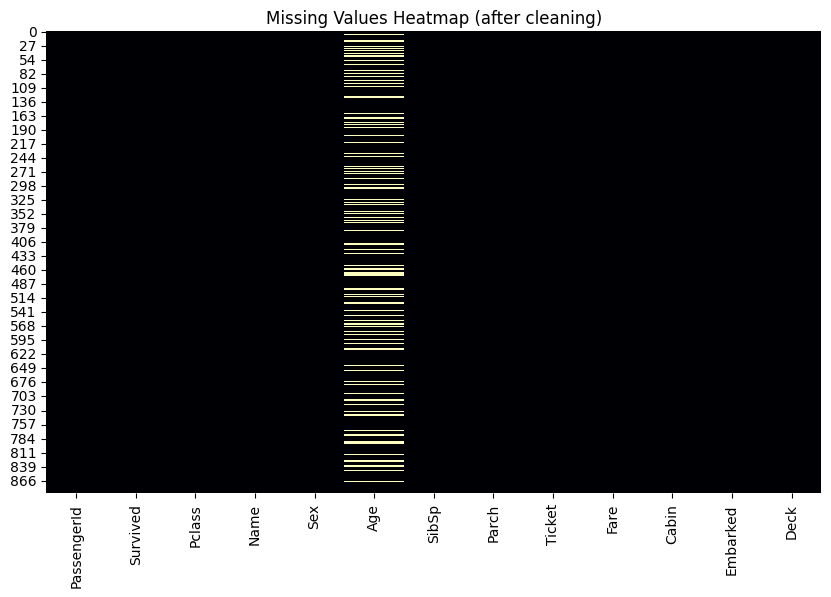

In [34]:
# Create a heatmap of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cmap="magma", cbar=False)
plt.title("Missing Values Heatmap (after cleaning)")
plt.show()

### Checking and converting the types

To male operations more effictient it is recommended effectively convert the types to the smallest possible data types. For example the 'Survived' feature is comprised of only 0 and 1, therefore it does not make sense for it to be an INT64 data type. A much more efficient type would be the boolean data type. 

In [10]:
# Type conversion of DF with removed values
t_df.loc[:, 'Pclass'] = t_df['Pclass'].astype('int8')
t_df.loc[:, 'Age'] = t_df['Age'].astype('int8')
t_df.loc[:, 'Parch'] = t_df['Parch'].astype('int8')
t_df.loc[:, 'Survived'] = t_df['Survived'].astype('bool')
t_df[['Pclass', 'Age', 'Survived', 'Parch', 'SibSp']] = t_df[['Pclass', 'Age', 'Survived','Parch', 'SibSp']].astype({'Pclass': 'int8', 'Age': 'int8', 'Survived': 'bool', 'Parch':'int8', 'SibSp':'int8'})

print(t_df.dtypes)

# Type conversion of DF with removed values & dropped columns
t_df_dropped[['Pclass', 'Age', 'Survived']] = t_df_dropped[['Pclass', 'Age', 'Survived']].astype({'Pclass': 'int8', 'Age': 'int8', 'Survived': 'bool'})

print(t_df_dropped_removed.dtypes)



IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

### Adapting the granularity 

In the original dataset the features 'SibSp' and 'Parch' are aggregates of information:
- SibSp refers to the number of siblings / spouses aboard the Titanic
- Parch refers to the number of parents / children aboard the Titanic

Even though we are not yet sure if we are going to need the data, it might be worthwhile to split up the data in the following, more granular way:

- Number of Siblings on board
- Number of Spouses on board
- Number of Parents on board
- Number of Children on board

To achieve this we need to find a way to appropriately split up the data. 

To find out if the value in 'Parch' refers to either children or parents an approach could be to check the age. If the age is below 16 it is unlikely that the value in Parch is referring to the number of children of that passenger. Please note that this is not a very precise way of handling the data. It needs to be checked latter, if this does not make the predictions less reliable.  

In [ ]:
# Checking the ages of all passengers from the original DF
age_counts = t_df['Age'].value_counts().sort_index()
print(age_counts)

Age
0.42     1
0.67     1
0.75     2
0.83     2
0.92     1
        ..
70.00    2
70.50    1
71.00    2
74.00    1
80.00    1
Name: count, Length: 88, dtype: int64


## Definition of the questions to be answered

The overall question is: What are the main factors that contributed to the survival rate of a passenger on the Titanic?

### Defining the assumptions to test

To build a successful model that attempts to predict survivability, it is first necessary to find related features. To find possible features that affect survivability, I first define some assumptions that I want to test:

- Age has an effect on survivability (due to the fitness of the individual)
- The cabin has an effect on survivability (due to proximity to exits, etc.)
- Class has an effect on survivability (due to the fact that higher class passengers had priority on emergency ships)
- Tickets and cabins are a proxy for class and therefore affect survivability (they reflect the class of passenger).

Please note that these assumptions are completely made up and based on intuition. They are just there to give me something to work with and investigate. Even if there is a relationship between survivability and the feature, this does not necessarily mean that there is a correlation or proof of my initial assumption.